In [1]:
%load_ext autoreload
%autoreload 2

### **CLIP-I, CLIP-T, DINO**

- **CLIP-I** - average pairwise cosine similarity between CLIP embeddings of generated and real images
- **CLIP-T** - average cosine similarity between prompt and CLIP embeddings of generated images
- **DINO** - average pairwise cosine similarity between the Vit-S/16 DINO embeddings of generated and real images

In [2]:
import os

os.chdir("/net/tscratch/people/plglukaszst/projects/ziplora-analysis/")

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.nn import functional as F
from transformers import AutoModel, AutoProcessor, AutoTokenizer
import argparse
import os

import torch
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline
import itertools


/net/tscratch/people/plglukaszst/envs/lora/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [6]:
def get_model_outs(pretrained_model_name_or_path: str, prompts:list, samples_per_prompt: int):
    model_path = pretrained_model_name_or_path
    diffusion_pipe = DiffusionPipeline.from_pretrained(
        model_path, torch_dtype=torch.float16
    )
    diffusion_pipe = diffusion_pipe.to("cuda")
    generator = torch.Generator("cuda")
    generator = generator.manual_seed(0)

    tasks_prompts = []
    tasks_samples = []
    for current_prompt in prompts:
        task_prompts = [current_prompt] * samples_per_prompt
        task_samples = diffusion_pipe(
            prompt=task_prompts, output_type="pil", generator=generator
        )
        task_prompts.append(task_prompts)
        tasks_samples.append(task_samples)

    return tasks_prompts, list(itertools.chain.from_iterable([out.images for out in tasks_samples]))

In [26]:
N_TASKS = 5
MODELS = ["watercolor_painting_style_sd1_rank256", "oil_painting_style_sd2_rank256", "colored_smoke_style_sd3_rank256", "wooden_sculpture_style_sd4_rank256", "cartoon_line_drawing_style_sd5_rank256"]
TOKENS = ["skn style", "zwz style", "sbu style", "uwu style", "pdw style"]
AFTER_TASK_MODEL = {
    k+1:v for k,v in zip(range(N_TASKS), MODELS)
}
TOKEN_TASK = {
    k+1: v for k,v in zip(range(N_TASKS), MODELS)
}

PROMPTS = ['a wizard in {}', 'a policeman in {}', 'a santa hat in {}', 'a clock in {}', 'a mirror in {}']


In [27]:
def run_model(task_number):
    if task_number >= 1:
        per_task_outs = {}
        for curr_task_number in range(task_number):
            task_outs = {}
            model_path = f"./models/rank/style/{AFTER_TASK_MODEL[task_number]}"
            prompts = [
                prompt.format(TOKEN_TASK[curr_task_number+1]) for prompt in PROMPTS
            ]
            out_prompts, out_samples = get_model_outs(pretrained_model_name_or_path=model_path, prompts=prompts, samples_per_prompt=8)
            task_outs["prompts"] = out_prompts
            task_outs["samples"] = out_samples
            per_task_outs[curr_task_number+1] = task_outs
        return per_task_outs
    else:
        per_task_outs = {}
        for curr_task_number in range(5):
            task_outs = {}
            model_path = f"stabilityai/stable-diffusion-xl-base-1.0"
            prompts = [
                prompt.format(TOKEN_TASK[curr_task_number+1]) for prompt in PROMPTS
            ]
            out_prompts, out_samples = get_model_outs(pretrained_model_name_or_path=model_path, prompts=prompts, samples_per_prompt=8)
            task_outs["prompts"] = out_prompts
            task_outs["samples"] = out_samples
            per_task_outs[curr_task_number+1] = task_outs
        return per_task_outs

In [9]:
task_outs_0 = run_model(0)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/net/tscratch/people/plglukaszst/envs/lora/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 8.00 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/net/tscratch/people/plglukaszst/envs/lora/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/net/tscratch/people/plglukaszst/envs/lora/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 24.01 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/net/

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
task_outs_1 = run_model(1)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
task_outs_2 = run_model(2)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
task_outs_3 = run_model(3)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
task_outs_4 = run_model(4)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
task_outs_5 = run_model(5)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [41]:
import pickle

with open("results_rank256.pkl", "wb") as f:
    pickle.dump([task_outs_0,task_outs_1,task_outs_2,task_outs_3,task_outs_4,task_outs_5],f)

In [ ]:
grid = image_grid(imgs, rows=8, cols=5)


# Metrics

In [33]:
DATASETS = ["watercolor_painting_style", "oil_painting_style", "colored_smoke_style", "wooden_sculpture_style", "cartoon_line_drawing_style"]

In [34]:
from lora.metrics import clip_image_metric, dino_metric

In [35]:
for task in range(5):
    model_samples = task_outs_0[task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

/net/tscratch/people/plglukaszst/envs/lora/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Task number: 0, CLIP: 0.5936103463172913, DINO: 0.2218233197927475
Task number: 1, CLIP: 0.5600571632385254, DINO: 0.07089140266180038
Task number: 2, CLIP: 0.6261627078056335, DINO: 0.18653252720832825
Task number: 3, CLIP: 0.6517712473869324, DINO: 0.2567393481731415
Task number: 4, CLIP: 0.4985247552394867, DINO: 0.42831817269325256


In [36]:
for task in range(1):
    model_samples = task_outs_1[task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6314317584037781, DINO: 0.4041808545589447


In [37]:
for task in range(2):
    model_samples = task_outs_2[task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6097226142883301, DINO: 0.28482845425605774
Task number: 1, CLIP: 0.6070818305015564, DINO: 0.2720974087715149


In [38]:
for task in range(3):
    model_samples = task_outs_3[task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6411687135696411, DINO: 0.29327940940856934
Task number: 1, CLIP: 0.5970920920372009, DINO: 0.16400940716266632
Task number: 2, CLIP: 0.7478613257408142, DINO: 0.39082106947898865


In [39]:
for task in range(4):
    model_samples = task_outs_4[task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.6149083375930786, DINO: 0.24281631410121918
Task number: 1, CLIP: 0.5654003024101257, DINO: 0.14737513661384583
Task number: 2, CLIP: 0.6246252059936523, DINO: 0.04183489456772804
Task number: 3, CLIP: 0.7621899843215942, DINO: 0.5071339011192322


In [40]:
for task in range(5):
    model_samples = task_outs_5[task+1]['samples']
    gt_path = os.path.join("data/styledrop/", DATASETS[task])
    print(f"Task number: {task}, CLIP: {clip_image_metric(model_samples, gt_path)}, DINO: {dino_metric(model_samples, gt_path)}")

Task number: 0, CLIP: 0.5909754633903503, DINO: 0.20504982769489288
Task number: 1, CLIP: 0.5474587678909302, DINO: 0.07990869134664536
Task number: 2, CLIP: 0.6293401122093201, DINO: 0.25962793827056885
Task number: 3, CLIP: 0.6726295351982117, DINO: 0.32778987288475037
Task number: 4, CLIP: 0.5590265393257141, DINO: 0.6091178059577942


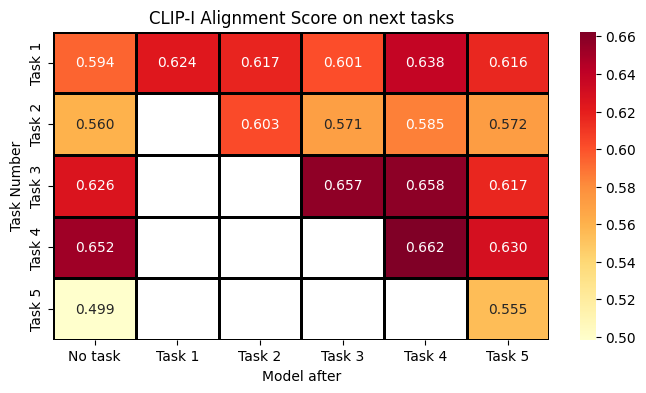

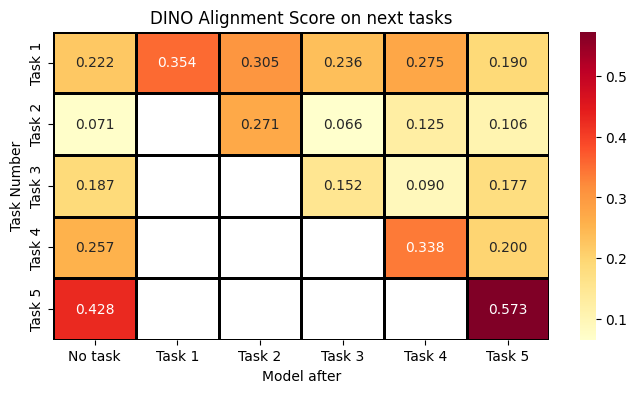

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Creating a matrix for the incremental model performance for heatmap
clip_matrix_updated = np.array([
    [0.5915667414665222, 0.557922899723053, 0.631373405456543, 0.649736762046814, 0.5014150142669678],
    [0.624005913734436, np.nan, np.nan, np.nan, np.nan],
    [0.6173079609870911, 0.6026208996772766, np.nan, np.nan, np.nan],
    [0.601495087146759, 0.5707738995552063, 0.6571434140205383, np.nan, np.nan],
    [0.6376327276229858, 0.5846818089485168, 0.6577308773994446, 0.6624749302864075, np.nan],
    [0.6157271862030029, 0.572004497051239, 0.6165396571159363, 0.6297092437744141, 0.5546650290489197]
]).T

dino_matrix_updated = np.array([
    [0.22539949417114258, 0.07449301332235336, 0.18638978898525238, 0.2520217299461365, 0.4309535622596741],
    [0.35372039675712585, np.nan, np.nan, np.nan, np.nan],
    [0.3050145208835602, 0.27117177844047546, np.nan, np.nan, np.nan],
    [0.23603737354278564, 0.06551206856966019, 0.1518050730228424, np.nan, np.nan],
    [0.27489903569221497, 0.12522797286510468, 0.0896523967385292, 0.3381164073944092, np.nan],
    [0.19007249176502228, 0.10566291958093643, 0.17658631503582, 0.19980619847774506, 0.5731788873672485]
]).T

tasks = ['No task','Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5']
colormap = 'YlOrRd'

# Plotting the heatmap for CLIP metric
plt.figure(figsize=(8, 4))
sns.heatmap(clip_matrix_updated, annot=True, fmt=".3f", cmap=colormap, xticklabels=tasks, yticklabels=tasks[1:], linewidths=.9, linecolor='black')
plt.title('CLIP-I Alignment Score on next tasks')
plt.xlabel('Model after')
plt.ylabel('Task Number')
plt.savefig("fig1styler256.svg")
plt.show()

# Plotting the heatmap for DINO metric
plt.figure(figsize=(8, 4))
sns.heatmap(dino_matrix_updated, annot=True, fmt=".3f", cmap=colormap, xticklabels=tasks, yticklabels=tasks[1:], linewidths=.9, linecolor='black')
plt.title('DINO Alignment Score on next tasks')
plt.xlabel('Model after')
plt.ylabel('Task Number')
plt.savefig("fig2styler256.svg")
plt.show()

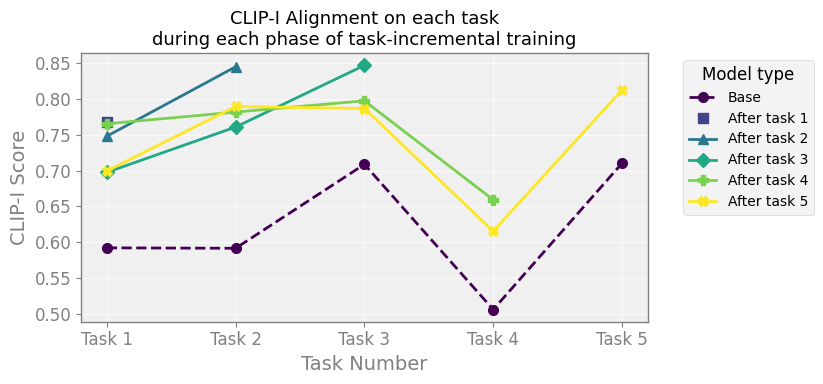

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot style and colors
plt.style.use('ggplot')
plt.rcParams.update({
    'axes.facecolor': '#f0f0f0',  # Light gray background for the plot area
    'figure.facecolor': '#ffffff',  # Light gray background for the figure
    'grid.color': 'white',
    'axes.edgecolor': 'gray',
    'axes.linewidth': 1.0,
    'axes.labelcolor': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray',
    'font.size': 12,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'figure.figsize': (14, 7)
})

plt.figure(figsize=(10, 4))

# Transpose the matrix for easier plotting
clip_matrix_updated_transposed = clip_matrix_updated.T

# Define a list of colors for each task finished
colors = plt.cm.viridis(np.linspace(0, 1, clip_matrix_updated_transposed.shape[1] + 1))
markers = ['o', 's', '^', 'D', 'P', 'X', 'H']

for task_finished in range(clip_matrix_updated_transposed.shape[1] + 1):
    if task_finished == 0:
        y = clip_matrix_updated_transposed[0, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='--', linewidth=2, markersize=7, label='Base')
    elif task_finished == 1:
        y = clip_matrix_updated_transposed[task_finished, 0]
        x = [1]
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='', markersize=7, label=f'After task {task_finished}')
    else:
        y = clip_matrix_updated_transposed[task_finished, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='-', linewidth=2, markersize=7, label=f'After task {task_finished}')

# Add title and labels
plt.title('CLIP-I Alignment on each task\nduring each phase of task-incremental training', fontsize=13)
plt.xlabel('Task Number', fontsize=14, color='gray')
plt.ylabel('CLIP-I Score', fontsize=14, color='gray')
plt.xticks(ticks=np.arange(1, len(tasks)), labels=tasks[1:], fontsize=12, color='gray')
plt.yticks(fontsize=12, color='gray')

# Add legend and grid
plt.legend(title='Model type', fontsize=10, title_fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='-', linewidth=0.7, color='white', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("fig3styler4.svg")

plt.show()


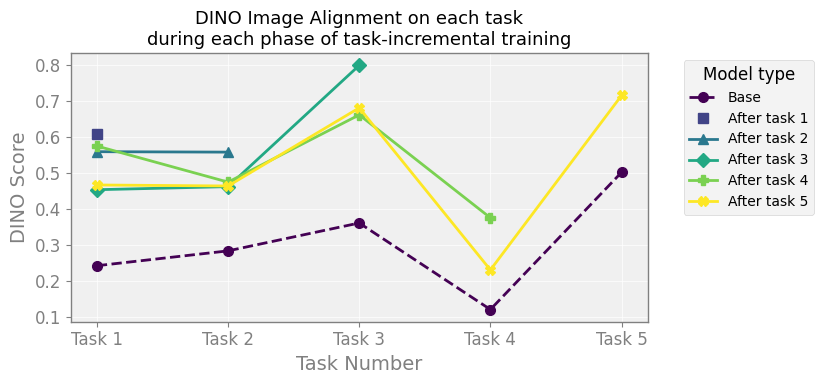

In [178]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot style and colors
plt.style.use('ggplot')
plt.rcParams.update({
    'axes.facecolor': '#f0f0f0',  # Light gray background for the plot area
    'figure.facecolor': '#ffffff',  # Light gray background for the figure
    'grid.color': 'white',
    'axes.edgecolor': 'gray',
    'axes.linewidth': 1.0,
    'axes.labelcolor': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray',
    'font.size': 12,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'figure.figsize': (14, 7)
})

plt.figure(figsize=(10, 4))

# Transpose the matrix for easier plotting
dino_matrix_updated_transposed = dino_matrix_updated.T

# Define a list of colors for each task finished
colors = plt.cm.viridis(np.linspace(0, 1, dino_matrix_updated_transposed.shape[1] + 1))
markers = ['o', 's', '^', 'D', 'P', 'X', 'H']

for task_finished in range(dino_matrix_updated_transposed.shape[1] + 1):
    if task_finished == 0:
        y = dino_matrix_updated_transposed[0, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='--', linewidth=2, markersize=7, label='Base')
    elif task_finished == 1:
        y = dino_matrix_updated_transposed[task_finished, 0]
        x = [1]
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='', markersize=7, label=f'After task {task_finished}')
    else:
        y = dino_matrix_updated_transposed[task_finished, :]
        x = np.arange(y.shape[0]) + 1
        plt.plot(x, y, marker=markers[task_finished], color=colors[task_finished], 
                 linestyle='-', linewidth=2, markersize=7, label=f'After task {task_finished}')

# Add title and labels
plt.title('DINO Image Alignment on each task\nduring each phase of task-incremental training', fontsize=13)
plt.xlabel('Task Number', fontsize=14, color='gray')
plt.ylabel('DINO Score', fontsize=14, color='gray')
plt.xticks(ticks=np.arange(1, len(tasks)), labels=tasks[1:], fontsize=12, color='gray')
plt.yticks(fontsize=12, color='gray')

# Add legend and grid
plt.legend(title='Model type', fontsize=10, title_fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='-', linewidth=0.7, color='white', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("fig4.png")

plt.show()
